## 데이터 다운로드

In [1]:
# $ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip
# $ unzip song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics  #lyrics 폴더에 압축풀기

## 데이터 읽어오기

In [27]:
import re    
import glob
import numpy as np         
import tensorflow as tf    
import os

txt_file_path = './data/lyrics/*.txt'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['The Cat in the Hat', 'By Dr. Seuss', 'The sun did not shine.']


## 데이터 정제

In [3]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx >15: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

The Cat in the Hat
By Dr. Seuss
The sun did not shine.
It was too wet to play.
So we sat in the house
All that cold cold wet day.
I sat there with Sally.
We sat there we two.
And I said How I wish
We had something to do!
Too wet to go out
And too cold to play ball.
So we sat in the house.
We did nothing at all.
So all we could do was to
Sit!


텍스트를 인공지능 모델에 학습시키기 위해서 데이터를 다듬어야 합니다.  

### 특수문자 제거하기

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()    
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.

<start> this is sample sentence . <end>


특수문자와 공백을 제거해서 우리가 원하는 데이터만 추출합시다.  
그리고 문장의 시작과 끝의 정보를 넣어줍니다.  

In [5]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> the cat in the hat <end>',
 '<start> by dr . seuss <end>',
 '<start> the sun did not shine . <end>',
 '<start> it was too wet to play . <end>',
 '<start> so we sat in the house <end>',
 '<start> all that cold cold wet day . <end>',
 '<start> i sat there with sally . <end>',
 '<start> we sat there we two . <end>',
 '<start> and i said how i wish <end>',
 '<start> we had something to do ! <end>']

특수문자가 성공적으로 제거 되었습니다.  

### 데이터 토큰화

In [6]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.
	
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                          maxlen=maxlen)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    6  903 ...    0    0    0]
 [   2  122 2584 ...    0    0    0]
 [   2    6  304 ...    0    0    0]
 ...
 [   2  673   27 ...    0    0    0]
 [   2  673   27 ...    0    0    0]
 [   2  673   27 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fddd4295410>


다음으로 데이터를 토큰화 시켜주는 작업을 시켜줍니다.  
문장을 쪼개서 기계가 이해할 수 있는 벡터로 변환시켜주는 과정입니다.  
여기서 평균 길이보다 큰 outlier가 있을 수 있으므로 maxlen을 설정해 제거해줍니다.

In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


토큰으로 잘 쪼개진 모습을 볼 수 있습니다.

In [8]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <END>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <START>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[   2    6  903   14    6 1350    3    0    0    0    0    0    0    0
    0    0    0    0    0]
[   6  903   14    6 1350    3    0    0    0    0    0    0    0    0
    0    0    0    0    0]


아까 설정한대로 길이를 20개로 맞추로 빈 공간은 0으로 채웠습니다. 

## 평가 데이터셋 분리

In [10]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [11]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (140599, 19)
Target Train:  (140599, 19)


In [12]:
from tensorflow.keras.layers import Embedding, LSTM, Dense

## 인공지능 만들기

### Model history 그래프

In [28]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습되는 과정을 시각화 하기 위해 함수를 정의해줍니다.

### 텍스트 생성 모델 정의

In [17]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 19
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

### 모델 학습

In [19]:
history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
550/550 [==============================] - 245s 446ms/step - loss: 3.0659 - val_loss: 2.6895
Epoch 2/10
550/550 [==============================] - 245s 446ms/step - loss: 2.5476 - val_loss: 2.4316
Epoch 3/10
550/550 [==============================] - 247s 450ms/step - loss: 2.3255 - val_loss: 2.2624
Epoch 4/10
550/550 [==============================] - 248s 451ms/step - loss: 2.1639 - val_loss: 2.1566
Epoch 5/10
550/550 [==============================] - 247s 448ms/step - loss: 2.0197 - val_loss: 2.0788
Epoch 6/10
550/550 [==============================] - 252s 459ms/step - loss: 1.8769 - val_loss: 2.0148
Epoch 7/10
550/550 [==============================] - 251s 457ms/step - loss: 1.7348 - val_loss: 1.9599
Epoch 8/10
550/550 [==============================] - 250s 455ms/step - loss: 1.5927 - val_loss: 1.9162
Epoch 9/10
550/550 [==============================] - 251s 456ms/step - loss: 1.4547 - val_loss: 1.8835
Epoch 10/10
550/550 [==============================] - 245s 446m

Epoch을 10번 돌렸더니 loss가 1점대로 떨어졌습니다.  
학습시간이 너무 길어서 여러번 돌리기에는 힘든 것 같습니다.

In [21]:
import matplotlib.pyplot as plt

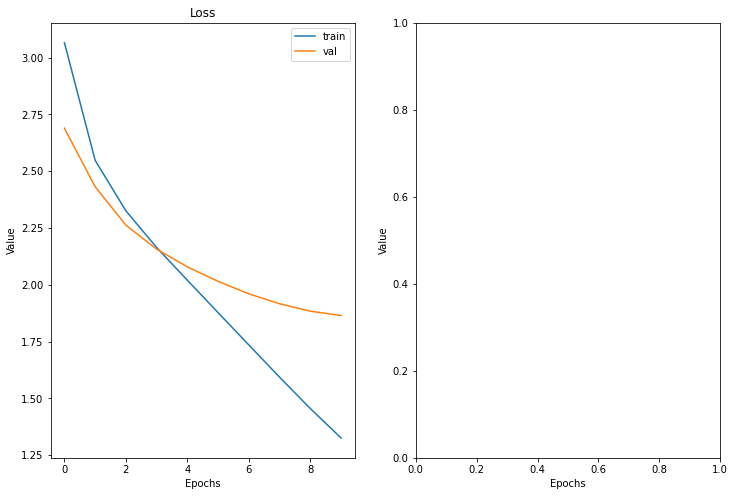

In [23]:
 plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

점점 loss값이 떨어지는 모습을 볼 수 있습니다

In [24]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측하지 않았거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

입력 받은 값을 예측해서 문장을 생성하는 모델입니다.  
함수는 다음과 같은 순서로 동작합니다.  

- 입력 받은 문장을 텐서로 변환합니다. 
- 루프를 돌면서 단어를 하나씩 생성합니다. 
- END나 max_len에 도달하면 루프를 탈출합니다.
- 예측한 텐서들을 사전을 통해 실제 단어로 변환합니다. 


In [26]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '

## 마무리

자연어 생성 모델은 사람이 생각하는 방식과 유사하게 동작합니다.  
이미지 처리에서도 그렇지만, 사람의 인식 패턴과 유사 해질수록 더 좋은 성능을 내는 것 같습니다.  
이번에는 한문장을 분석하는 모델을 만들었습니다.  
문장이 문단이 되고, 글이 되는 모델을 만든다면 더욱 흥미롭겠다는 생각이 들었습니다.  
<bn> 
    
자연어처리는 영상처리보다 파라미터 개수가 더 많은 것 같습니다.  
아마도 학습하는 벡터가 더 많아서 그런것 같습니다.  
이부분을 개선한 모델이 있다면, 더 공부해보고 싶습니다. 